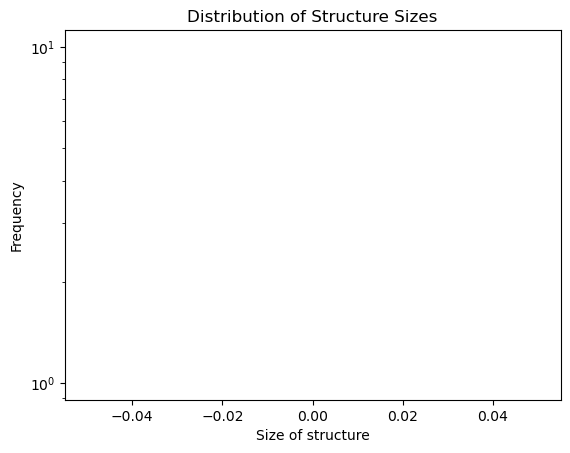

In [2]:
import numpy as np
from scipy.ndimage import label
import matplotlib.pyplot as plt


import numpy as np

NO_STRUCTURE = 0
STRUCTURE = 2


class Model:
    """This class represents the model of the city.
    It contains the grid and the methods modify it, as well as different calculations for the model.
    """

    gird = None

    def __init__(self, w=200, h=200) -> None:
        """Initialize the model with a grid of size w*h"""
        self.w = w
        self.h = h

        self.grid = np.zeros((self.w, self.h))

        # Set the center of the grid to be a city
        self.grid[self.w // 2, self.h // 2] = STRUCTURE

    def loop(self, n=100, stickiness=0.9):
        """Run the model for `n' iterations"""
        for _ in range(n):
            self.update(stickiness)

    def update(self, stickiness=0.9):
        """Update the model by adding a random walker to the grid. If the random walker is next to a city, it will become a city with probability `stickiness'"""

        # Set the walker to be a particle at a random point on the edge of a circle
        angle = np.random.uniform(0, 2 * np.pi)
        x = int(self.w // 2 + self.w // 2 * np.cos(angle))
        y = int(self.h // 2 + self.h // 2 * np.sin(angle))
        old_x, old_y = x, y

        while self.grid[x, y] == NO_STRUCTURE:
            old_x, old_y = x, y

            # Move the walker
            direction = np.random.randint(0, 4)
            if direction == 0:
                x += 1
            elif direction == 1:
                x -= 1
            elif direction == 2:
                y += 1
            else:
                y -= 1

            # Check if the walker is within bounds
            if x < 0:
                x = 0
            elif x >= self.w:
                x = self.w - 1

            if y < 0:
                y = 0
            elif y >= self.h:
                y = self.h - 1

            # Check if the walker moved into a city
            if self.grid[x, y] == STRUCTURE and np.random.rand() > stickiness:
                x, y = old_x, old_y

            # 检查是否接触到结构
            if self.grid[x, y] == STRUCTURE:
                break

        # Set the walker to be a city
        self.grid[x, y] = STRUCTURE

    def get_fractal_dim(self, n_boxes=10):
        """Calculate the fractal dimension using the box counting method.

        This method divides the grid into n_boxes*n_boxes boxes and counts the number of boxes that contain a city.
        The result can be used to calculate the fractal dimension using the following formula:
        D = log(N) / log(1 / s)
        where N is the number of boxes that contain a city and s is the size of each box.

        https://en.wikipedia.org/wiki/Minkowski%E2%80%93Bouligand_dimension
        https://en.wikipedia.org/wiki/Box_counting"""

        # The size of each box
        box_size = self.w // n_boxes

        # The number of boxes that contain a city
        n_filled_boxes = 0

        # Loop over all boxes
        for i in range(n_boxes):
            for j in range(n_boxes):
                # Check if the box contains a city
                if np.any(
                    self.grid[
                        i * box_size : (i + 1) * box_size,
                        j * box_size : (j + 1) * box_size,
                    ]
                    == STRUCTURE
                ):
                    n_filled_boxes += 1

        # Calculate the fractal dimension
        return np.log(n_filled_boxes) / np.log(n_boxes)

# 创建模型实例
model = Model(w=200, h=200)
# 运行模型
model.loop(n=1000)

# 标记结构并计算它们的大小 Marking structures and calculating their size
labeled_grid, num_features = label(model.grid == STRUCTURE)

# Exclusion of structures touching the border
border_labels = np.unique(np.concatenate([
    labeled_grid[0, :], labeled_grid[:, 0], labeled_grid[-1, :], labeled_grid[:, -1]
]))
sizes = np.array([np.sum(labeled_grid == i) for i in range(1, num_features + 1) if i not in border_labels])

# histogram
if sizes.size > 0:
    plt.hist(sizes, bins=range(1, max(sizes) + 1), log=True)
    plt.xlabel('Size of structure')
    plt.ylabel('Frequency')
    plt.title('Distribution of Structure Sizes')
    plt.show()
else:
    print("Not enough data points to create a histogram.")


In [3]:
import powerlaw
results = powerlaw.Fit(sizes)

# Retrieve parameters of the power-law distribution
print('Power-law exponent alpha:', results.power_law.alpha)
print('Minimum value for power-law distribution xmin:', results.power_law.xmin)
print('Standard error sigma:', results.power_law.sigma)

# Compare the goodness of fit between power-law and exponential distributions
R, p = results.distribution_compare('power_law', 'exponential')
print('Comparison result R:', R)
print('p-value:', p)

# Compare the goodness of fit between power-law and lognormal distributions
R, p = results.distribution_compare('power_law', 'lognormal')
print('Comparison result R:', R)
print('p-value:', p)

Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/Users/haha/anaconda3/lib/python3.11/site-packages/powerlaw.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data/self.xmin)))


Power-law exponent alpha: nan
Minimum value for power-law distribution xmin: nan
Standard error sigma: nan
Comparison result R: 0
p-value: 1
Comparison result R: 0
p-value: 1


/Users/haha/anaconda3/lib/python3.11/site-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
/Users/haha/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/haha/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
No valid fits found.
Not enough data. Returning nan
/Users/haha/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/haha/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div,

In [4]:
import numpy as np

# density gradient 

def density_gradient(grid, center):
    distances = []
    densities = []
    for radius in range(1, center):
        mask = (np.fromfunction(lambda i, j: np.sqrt((i-center)**2 + (j-center)**2), grid.shape) < radius)
        densities.append(np.sum(grid[mask]) / np.pi / radius**2)
        distances.append(radius)
    return distances, densities

distances, densities = density_gradient(model.grid, model.w // 2)

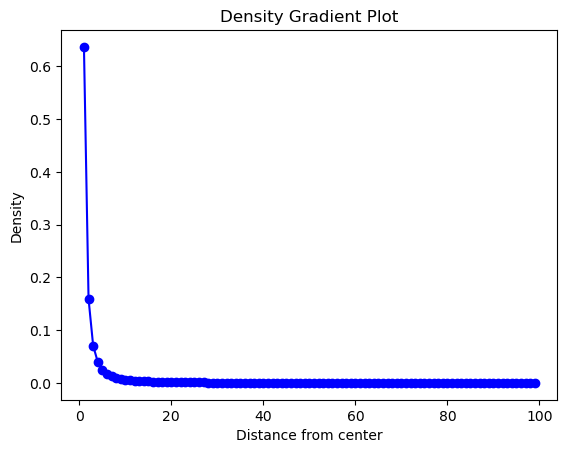

In [5]:
plt.plot(distances, densities, '-o', color='blue')
plt.xlabel('Distance from center')
plt.ylabel('Density')
plt.title('Density Gradient Plot')
plt.show()

In [41]:
import powerlaw

# Fit the distance data using powerlaw
results = powerlaw.Fit(densities)

# Retrieve the parameters of the power-law distribution and comparison results
print('Power-law exponent alpha:', results.power_law.alpha)
print('Minimum value for power-law distribution xmin:', results.power_law.xmin)
R, p = results.distribution_compare('power_law', 'exponential')
print('Comparison result R between power-law and exponential distributions:', R)
print('p-value:', p)



Calculating best minimal value for power law fit
Power-law exponent alpha: 1.5167950034650266
Minimum value for power-law distribution xmin: 6.495457324432011e-05
Comparison result R between power-law and exponential distributions: 246.052800967365
p-value: 3.7018391932551564e-06


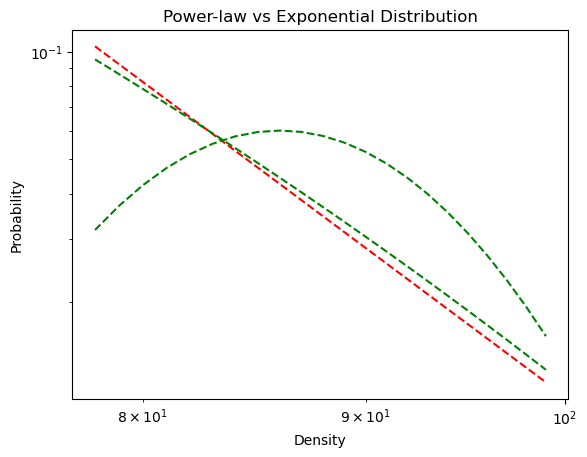

In [50]:
fig, ax = plt.subplots()
results.plot_pdf(color='b', linewidth=2)
results.power_law.plot_pdf(color='r', linestyle='--', ax=ax)
results.exponential.plot_pdf(color='g', linestyle='--', ax=ax)
results.lognormal.plot_pdf(color='g', linestyle='--', ax=ax, label='Lognormal Fit') 
plt.xlabel('Density')
plt.ylabel('Probability')
plt.title('Power-law vs Exponential Distribution')
plt.show()


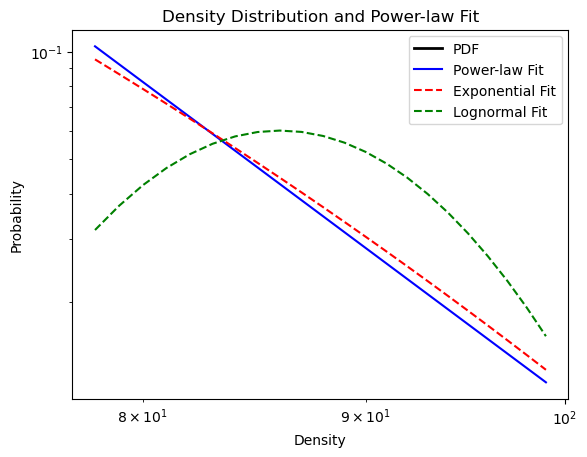

In [57]:
fig, ax = plt.subplots()
results.plot_pdf(color='black', linewidth=2, label = 'PDF')
results.power_law.plot_pdf(color='b', ax=ax, label='Power-law Fit') 
results.exponential.plot_pdf(color='r', linestyle='--', ax=ax, label='Exponential Fit')  
results.lognormal.plot_pdf(color='g', linestyle='--', ax=ax, label='Lognormal Fit') 
plt.xlabel('Density')
plt.ylabel('Probability')
plt.title('Density Distribution and Power-law Fit')
plt.legend() 
plt.show()

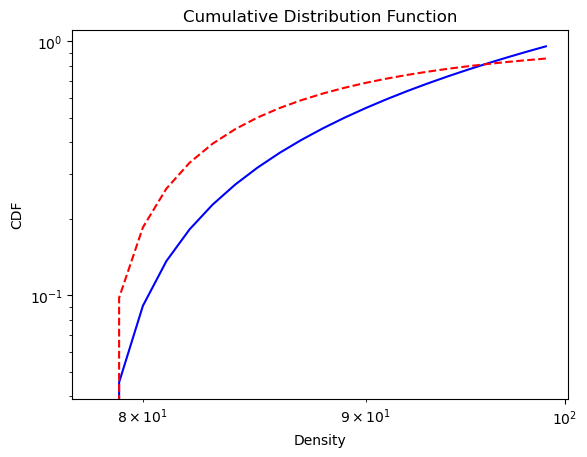

In [54]:
fig, ax = plt.subplots()
results.plot_cdf(color='b')  # 蓝色线表示原始数据的累积分布函数 (CDF)
results.power_law.plot_cdf(color='r', linestyle='--', ax=ax)  # 红色虚线表示拟合的幂律分布的 CDF
plt.xlabel('Density')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function')
plt.show()


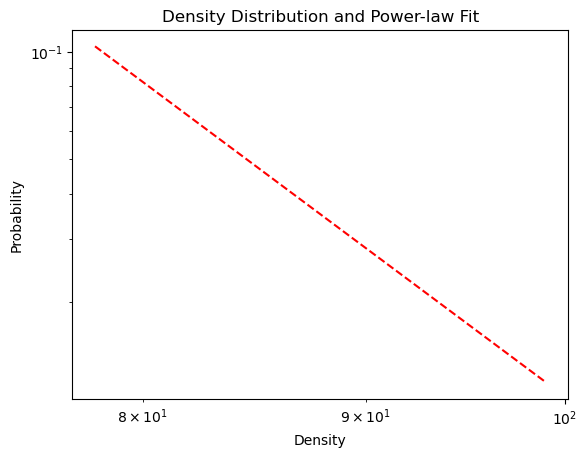

In [55]:
fig, ax = plt.subplots()
results.plot_pdf(color='b', linewidth=2)
results.power_law.plot_pdf(color='r', linestyle='--', ax=ax)
plt.xlabel('Density')
plt.ylabel('Probability')
plt.title('Density Distribution and Power-law Fit')
plt.show()


In [56]:
results = powerlaw.Fit(distances)

# Retrieve the parameters of the power-law distribution and comparison results
print('Power-law exponent alpha:', results.power_law.alpha)
print('Minimum value for power-law distribution xmin:', results.power_law.xmin)
R, p = results.distribution_compare('power_law', 'exponential')
print('Comparison result R between power-law and exponential distributions:', R)
print('p-value:', p)


Calculating best minimal value for power law fit
Power-law exponent alpha: 9.083271777305292
Minimum value for power-law distribution xmin: 78.0
Comparison result R between power-law and exponential distributions: -0.863479932240931
p-value: 0.0005230821911741857
